# Example 02 - On-the-fly Generation of a Sig53-like Dataset
This notebook walks through an example of how the code used to generate the Sig53 dataset can be used in an on-the-fly manner when sufficient disk space is not available. Note that calling this dataset Sig53 could be confusing, as it's not bit-for-bit the same as Sig53 (which is generated staticly).

----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit.

In [1]:
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer
from torchsig.datasets.modulations import ModulationsDataset
from torchsig.utils.writer import DatasetCreator, DatasetLoader
from torchsig.utils.dataset import SignalDataset
from torchsig.datasets.sig53 import Sig53
from torchsig.datasets import conf
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm
import numpy as np
import os

In [2]:
train_config = conf.Sig53CleanTrainConfig

train_dataset = ModulationsDataset(
    level=train_config.level,
    num_samples=train_config.num_samples,
    num_iq_samples=train_config.num_iq_samples,
    use_class_idx=train_config.use_class_idx,
    include_snr=train_config.include_snr,
    eb_no=train_config.eb_no,
)

val_config = conf.Sig53CleanValConfig
val_dataset = ModulationsDataset(
    level=train_config.level,
    num_samples=val_config.num_samples,
    num_iq_samples=val_config.num_iq_samples,
    use_class_idx=val_config.use_class_idx,
    include_snr=val_config.include_snr,
    eb_no=val_config.eb_no,
)


In [4]:
# Retrieve a sample and print out information
idx = np.random.randint(len(train_dataset))
data, (label, snr) = train_dataset[idx]
print("Dataset length: {}".format(len(train_dataset)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))
print("SNR: {}".format(snr))

Dataset length: 1060000
Data shape: (4096,)
Label Index: 29
Label Class: 4fsk
SNR: [100.]


----
### Plot Subset to Verify
The `IQVisualizer` and the `SpectrogramVisualizer` can be passed a `Dataloader` and plot visualizations of the dataset. The `batch_size` of the `DataLoader` determines how many examples to plot for each iteration over the visualizer. Note that the dataset itself can be indexed and plotted sequentially using any familiar python plotting tools as an alternative plotting method to using the `torchsig` `Visualizer` as shown below.

In [5]:
# For plotting, omit the SNR values
class DataWrapper(SignalDataset):
    def __init__(self, dataset):
        self.dataset = dataset
        super().__init__(dataset)

    def __getitem__(self, idx):
        x, (y, _) = self.dataset[idx]
        return x, y

    def __len__(self) -> int:
        return len(self.dataset)

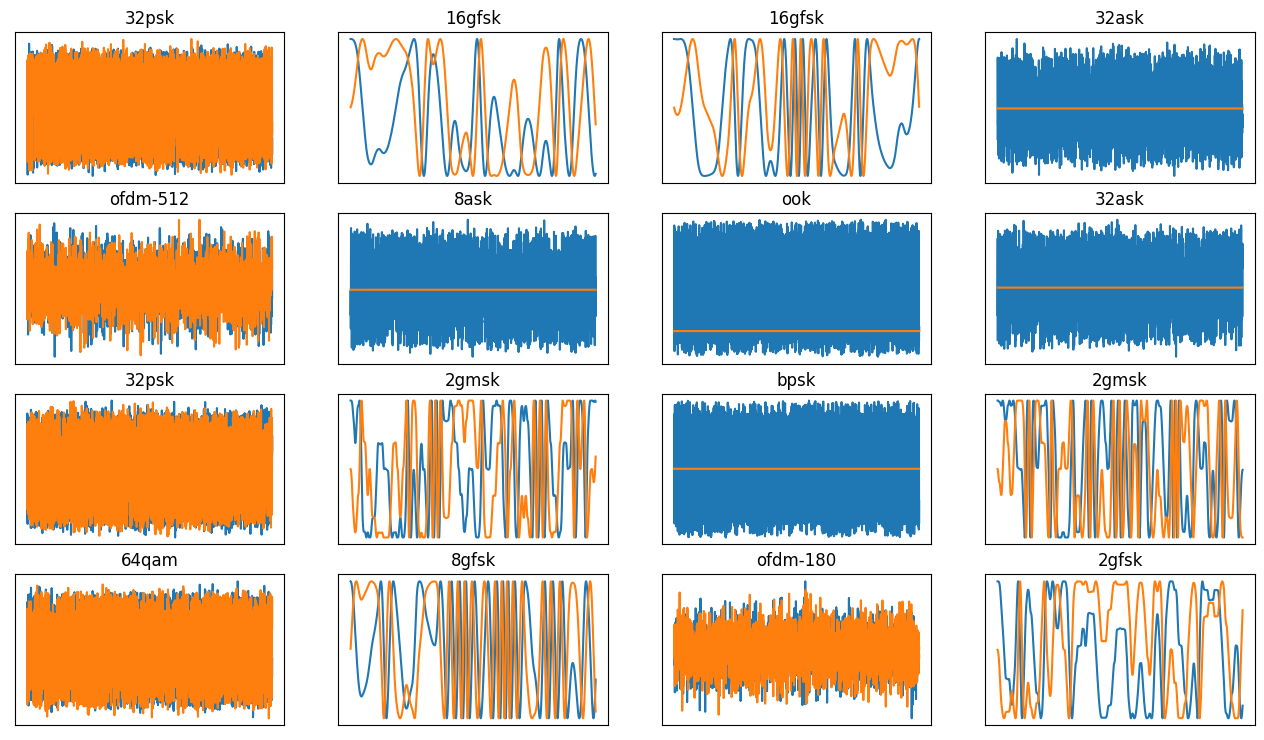

In [9]:
plot_dataset = DataWrapper(train_dataset)

data_loader = DataLoader(dataset=plot_dataset, batch_size=16, shuffle=True)

# Transform the plotting titles from the class index to the name
def target_idx_to_name(tensor: np.ndarray) -> List[str]:
    batch_size = tensor.shape[0]
    label = []
    for idx in range(batch_size):
        label.append(Sig53.convert_idx_to_name(int(tensor[idx])))
    return label


visualizer = IQVisualizer(
    data_loader=data_loader,
    visualize_transform=None,
    visualize_target_transform=target_idx_to_name,
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 9)
    plt.show()
    break

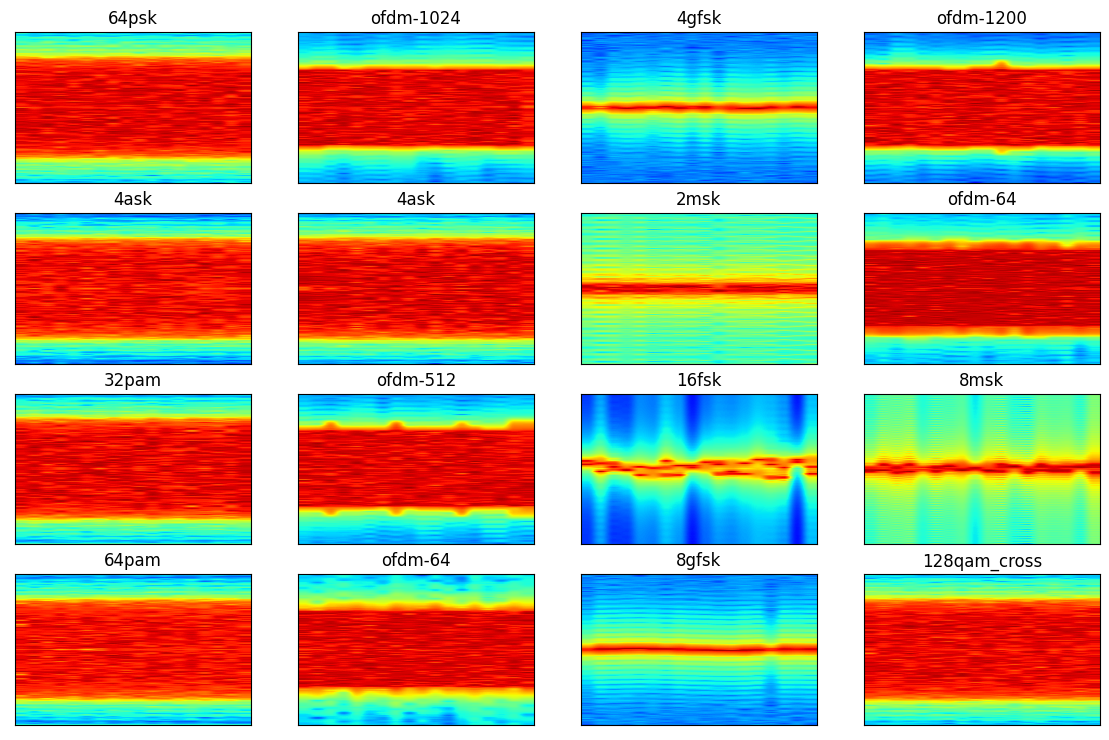

In [10]:
# Repeat but plot the spectrograms for a new random sampling of the data
visualizer = SpectrogramVisualizer(
    data_loader=data_loader,
    nfft=1024,
    visualize_transform=None,
    visualize_target_transform=target_idx_to_name,
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

----
### Analyze Dataset
The dataset can also be analyzed at the macro level for details such as the distribution of classes and SNR values. This exercise is performed below to show the nearly uniform distribution across each.

In [ ]:
# Loop through the dataset recording classes and SNRs
class_counter_dict = {
    class_name: 0 for class_name in list(Sig53._idx_to_name_dict.values())
}
all_snrs = []

for idx in tqdm(range(len(train_dataset))):
    data, (modulation, snr) = train_dataset[idx]
    class_counter_dict[Sig53.convert_idx_to_name(modulation)] += 1
    all_snrs.append(snr)

In [ ]:
# Plot the distribution of classes
class_names = list(class_counter_dict.keys())
num_classes = list(class_counter_dict.values())

plt.figure(figsize=(9, 9))
plt.pie(num_classes, labels=class_names)
plt.title("Class Distribution Pie Chart")
plt.show()

plt.figure(figsize=(11, 4))
plt.bar(class_names, num_classes)
plt.xticks(rotation=90)
plt.title("Class Distribution Bar Chart")
plt.xlabel("Modulation Class Name")
plt.ylabel("Counts")
plt.show()

In [ ]:
# Plot the distribution of SNR values
plt.figure(figsize=(11, 4))
plt.hist(x=all_snrs, bins=100)
plt.title("SNR Distribution")
plt.xlabel("SNR Bins (dB)")
plt.ylabel("Counts")
plt.show()